# Simulations
In this notebook we will show four methods for incorporating new simulations into Coba in order of easy to hard:
1. From an Openml.org dataset with **OpenmlSimulation**
2. From local data sets with **CsvSimulation**, **ArffSimulation**, **LibsvmSimulation**, and **ManikSimulation**.
3. From Python function definitions with **LambdaSimulation**
4. From your own class that implements the **Simulation** interface

## Simulations From Openml.org

Perhaps the easiest way to incorporate new Simulations is to load them from Openml.org. Openml.org is is an online repository of machine learning data sets which currently hosts over 21,000 datasets. Using dataset ids Coba can tap into this repository and download these datasets to create Simulations.

To get a sense of how this works let's say we want to build a simulation from the Covertype data set. We can [do a dataset search](https://www.openml.org/search?type=data) on Openml.org to see if this data set is hosted. [This search](https://www.openml.org/search?q=covertype&type=data) finds several data sets and we simply pick [the first one](https://www.openml.org/d/180). On the dataset's landing page we can look at the URL -- https://www.openml.org/d/180 -- to get the dataset's id of 180. Now, all we have to do to run an experiment with the Covertype data set is:


2021-06-13 11:15:41 Processing chunk...
2021-06-13 11:15:46   * Creating source 0 from {"OpenmlSimulation":180}... (4.83 seconds)
2021-06-13 11:15:46   * Creating simulation 0 from source 0... (0.0 seconds)
2021-06-13 11:15:46   * Evaluating learner 1 on Simulation 0... (0.26 seconds)
2021-06-13 11:15:46   * Evaluating learner 0 on Simulation 0... (0.04 seconds)


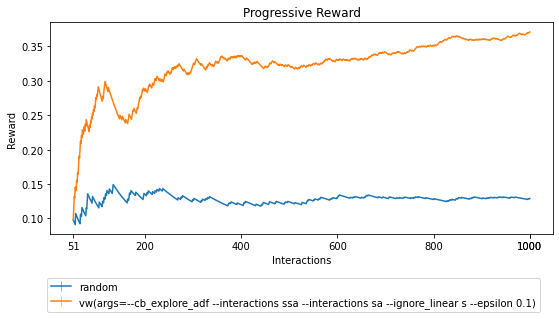

In [1]:
from coba.simulations import OpenmlSimulation
from coba.learners    import RandomLearner, VowpalLearner
from coba.benchmarks  import Benchmark

Benchmark([OpenmlSimulation(180)], take=1000).evaluate([RandomLearner(), VowpalLearner(epsilon=0.1)]).plot_learners()

This same procedure can be repeated for any dataset on Openml.org.

## Simulations From Local Datasets

The next easiest way to incorporate new Simulations is to load them from a local dataset. Coba can create simulations from datasets in the following formats:
* CSV
* ARFF (i.e., https://waikato.github.io/weka-wiki/formats_and_processing/arff_stable/)
* Libsvm (e.g., https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html)
* Manik (e.g., http://manikvarma.org/downloads/XC/XMLRepository.html)

For example, we may want to test against the mnist dataset. This dataset can be download from Libsvm [here](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#mnist). Once downloaded it we could use it:

```python
from coba.simulations import LibsvmSimulation
from coba.learners    import RandomLearner, VowpalLearner
from coba.benchmarks  import Benchmark

mnist = [LibsvmSimulation(<path to downloaded mnist>)] 
Benchmark(mnist, take=1000).evaluate([RandomLearner(), VowpalLearner(epsilon=0.1)]).plot_learners()
```

The complete list of classes for local simulations is:

* `CsvSimulation(source:str, label_col:Union[str,int], with_header:bool=True)`
* `ArffSimulation(source:str, label_col:Union[str,int])`
* `LibsvmSimulation(source:str)`
* `ManikSimulation(source:str)`

## Simulations from Function Definitions

A third method for creating simulations for use in experiments is via function definitions. 

This can be done with **LambdaSimulation** which takes three function definitions -- describing how to generate contexts, actions and rewards -- and the number of interactions you'd like the simulation to have. An example of a **LambdaSimulation** generating random contexts and actions with a linear reward function in [0,1] is provided:


2021-06-13 11:15:46 Processing chunk...
2021-06-13 11:15:46   * Creating source 0 from "LambdaSimulation"... (0.0 seconds)
2021-06-13 11:15:46   * Creating simulation 0 from source 0... (0.0 seconds)
2021-06-13 11:15:46   * Evaluating learner 1 on Simulation 0... (0.18 seconds)
2021-06-13 11:15:47   * Evaluating learner 0 on Simulation 0... (0.04 seconds)


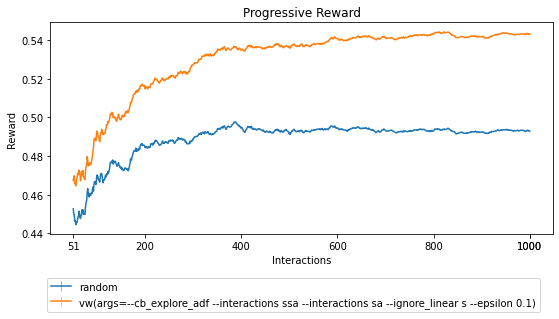

In [2]:
from typing import Sequence

from coba.random      import CobaRandom
from coba.simulations import LambdaSimulation, Context, Action
from coba.learners    import RandomLearner, VowpalLearner
from coba.benchmarks  import Benchmark

r = CobaRandom()
n_interactions = 1000

def context(index: int) -> Context:
    return tuple(r.randoms(5))

def actions(index: int, context: Context) -> Sequence[Action]:
    actions = [ r.randoms(5) for _ in range(3) ]
    return [ tuple(a/sum(action) for a in action) for action in actions ]

def rewards(index: int, context: Context, action: Action) -> float:
    return sum(c*a for c,a in zip(context,action))

simulations = [LambdaSimulation(n_interactions, context, actions, rewards)]

Benchmark(simulations).evaluate([RandomLearner(), VowpalLearner()]).plot_learners()


## Simulations from Scratch

The final, and most involved method, for creating new simulations in Coba is to create your own from scratch. This might be needed if you need to ingest a format that Coba doesn't already support. Or maybe you need your simulation to track some internal state between interactions. By creating your own Simulation there really is no limit to the functionality employed. In order to make your own simulation you'll first need to know a few simple classes/interfaces. We'll start with the Simulation interface.


### Simulation Interface

A Simulation in Coba is any class with the following interface:

```python
class Simulation:

    @property
    @abstractmethod
    def interactions(self) -> Sequence[Interaction]:
        ...

    @property
    @abstractmethod
    def reward(self) -> Reward:
        ...
```

So long as your class satisfies this interface it should be completely interoperable with Coba. However, assuming you have access to coba classes there really isn't any reason to implement this interface yourself. In practice it should always suffice to use MemorySimulation (more on this soon).

### Interaction Interface

As seen above the Simulation interface relies on the Interaction interface:

```python
class Interaction:
    @property
    @abstractmethod
    def key(self) -> Key: 
        ...
        
    @property
    @abstractmethod
    def context(self) -> Context:
        ...
        
    @property
    @abstractmethod
    def actions(self) -> Sequence[Action]:
        ...
```

Once again, while one can satisfy this interface from scratch we recommend developers simply use Coba's Interaction class. The types hints of Key, Context and Action actually have no constraints on them. We simply provide them for semantic interpretation and you are free to actually return anything you'd like as a key, context or collection of actions.

### Reward Interface

The final interface that Simulations depend upon is the Reward interface:

```python
class Reward:
    @abstractmethod
    def observe(choices: Sequence[Tuple[Key,Context,Action]]) -> Sequence[float]:
        ...
```

Out of the box Coba provides a ClassificationReward which returns values of 1 or 0 depending on if Action is the true label associated with the observation uniquely identified by Key. For example, if a simulation is loaded from Csv then Key will be the row number of the given observation we are trying to label in the Csv file. Coba also provides MemoryReward which can be useful if Key is hashable and Action are hashable and it is possible to compute all rewards up front.

### Source Interface

Once you have created your custom Simulation there is one more interface to contend with, the Source interface:

```python
class Source[Simulation]:
    
    @abstractmethod
    def read(self) -> Simulation:
        ...
        
    def __repr__(self) -> str:
        ...
```

When performing experiments Coba's benchmark actually expects to be given a Source that produces a Simulation rather than an actual Simulation. All standard simulations such as OpenmlSimulation, CsvSimulation, and LambdaSimulation are actually Sources.
The source pattern allows Simulations to be lazy loaded in background processes thereby saving time and resources. Converting a custom Simulation to a Source is fairly easy. Below is an example pattern that could be followed:

2021-06-13 11:15:47 Processing chunk...
2021-06-13 11:15:47   * Creating source 0 from MySimulation... (0.0 seconds)
2021-06-13 11:15:47   * Creating simulation 0 from source 0... (0.0 seconds)
2021-06-13 11:15:47   * Evaluating learner 1 on Simulation 0... (0.01 seconds)
2021-06-13 11:15:47   * Evaluating learner 0 on Simulation 0... (0.0 seconds)


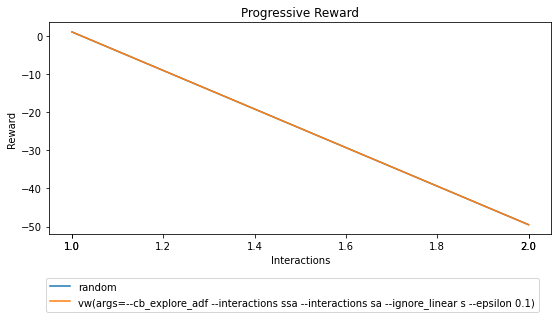

In [3]:
from coba.simulations import Interaction, MemoryReward
from coba.learners    import RandomLearner, VowpalLearner
from coba.benchmarks  import Benchmark

class MySimulation:
    
    class MyLoadedSimulation:
        
        @property
        def interactions(self):
            return [ Interaction(1, (1,1), [1,2,3]), Interaction(2, (2,2), [1,2,3]) ]
        
        @property
        def reward(self):
            return MemoryReward([ (1,1,1), (1,2,2), (1,3,3), (2,1,2), (2,2,100), (2,3,-100) ])
        
    def read(self):
        return MySimulation.MyLoadedSimulation()
    
    def __repr__(self):
        return "MySimulation"

Benchmark([MySimulation()]).maxtasksperchild(None).evaluate([RandomLearner(), VowpalLearner()]).plot_learners()